In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util, visualization_utils as viz_utils
import cv2 
import numpy as np
from matplotlib import pyplot as plt

from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime
import time as tm  # Import the time module with an alias

import csv


## **Start Tfod**

### ***Roi***

In [ ]:
def roi_it(image,detections,detection_threshold):   
    # scores, boxes and classes above threshold
    image=image_np_with_detections
    scores=list(filter(lambda x:x> detection_threshold,detections['detection_scores']))
    boxes=detections['detection_boxes'][:len(scores)]
    classes=detections['detection_classes'][:len(scores)]

    # full image dimension
    width =image.shape[1]
    height =image.shape[0]
    
    #Apply ROI filtering and OCR
    for indx, box in enumerate(boxes):    
        roi=box*[height,width,height,width]
        region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])] #actual region exactracting image
        #plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))
        #plt.show()
        return region

### ***saveTheRoi***

In [ ]:
def save_results(region, folder_path):
    #current_datetime = datetime.now().strftime("%d-%m-%Y-%H%M%S-%f") #seperate dd-mm-yyy-time
    current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S_%f") #seperate YearMonthDate_hourMinutesSecond_milisecond 
    img_name = '{}.jpg'.format(current_datetime)
    # Check if the folder exists, if not, create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    cv2.imwrite(os.path.join(folder_path, img_name), region)

### ***objectDetection***

##### *from image*

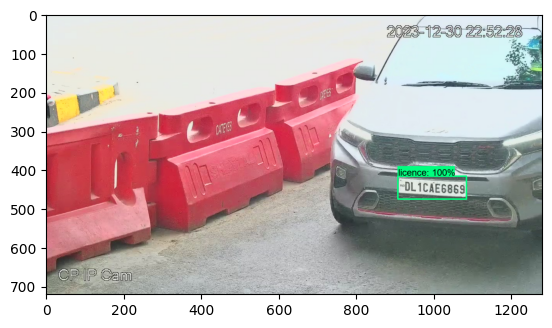

In [7]:
MODEL_PATH = 'D:\\AnprProject\\myModels\\tfodModel\\export\\saved_model'
LABEL_MAP_NAME = 'label_map.pbtxt'
#ANNOTATION_PATH = os.path.join('Tensorflow', 'workspace', 'annotations')
ANNOTATION_PATH = os.path.join('Annotations','annotations_tfod')
LABELMAP = os.path.join(ANNOTATION_PATH, LABEL_MAP_NAME)

# Ensure annotation path exists
os.makedirs(ANNOTATION_PATH, exist_ok=True)

# Create label map
labels = [{'name':'licence', 'id':1}]
with open(LABELMAP, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Load the TensorFlow saved model
model = tf.saved_model.load(MODEL_PATH)
category_index = label_map_util.create_category_index_from_labelmap(LABELMAP)
# Assuming the function signature is 'serving_default' and it takes an image tensor
infer = model.signatures['serving_default']

# Define the detection function
def detect_fn(image):
    input_tensor = tf.convert_to_tensor(image, dtype=tf.uint8)  # Convert to uint8
    input_tensor = input_tensor[tf.newaxis, ...]
    output_dict = infer(input_tensor)
    return output_dict

# Read and preprocess the input image
IMAGE_PATH = r'C:\Users\Msdn08\Desktop\Test_Img\img (322).jpg'
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

# Run detection
detections = detect_fn(image_np)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# Convert detection_classes to integers
detections['detection_classes'] = detections['detection_classes'].astype(int)

# Visualization
label_id_offset = 0
image_np_with_detections = image_np.copy()
min_threshold=0.6
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'] + label_id_offset,  # Ensure detection classes are integers
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=10,
    min_score_thresh=min_threshold,
    agnostic_mode=False
)
try:
    region=roi_it(image_np_with_detections,detections,min_threshold)   
    #save_results(region,'Detected_Images')
except:
    pass
# Display the result
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

##### *from videoCam*

In [ ]:
MODEL_PATH = 'D:\\anprNew\\tfodModel\\export\\saved_model'
LABEL_MAP_NAME = 'label_map.pbtxt'
ANNOTATION_PATH = os.path.join('Annotations','annotations_tfod')
LABELMAP = os.path.join(ANNOTATION_PATH, LABEL_MAP_NAME)

# Ensure annotation path exists
os.makedirs(ANNOTATION_PATH, exist_ok=True)

# Create label map
labels = [{'name':'licence', 'id':1}]
with open(LABELMAP, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Load the TensorFlow saved model
model = tf.saved_model.load(MODEL_PATH)

# Assuming the function signature is 'serving_default' and it takes an image tensor
infer = model.signatures['serving_default']

# Define the detection function
def detect_fn(image):
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]
    output_dict = infer(input_tensor)
    return output_dict

# Set up video capture
cap = cv2.VideoCapture(r'C:\Users\Msdn08\Desktop\Test_Img\testvideo2.mp4')

# Create category index
category_index = label_map_util.create_category_index_from_labelmap(LABELMAP)

# Processing frames in the video
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Ignoring empty camera frame.")
        continue
    
    # Convert frame to numpy array
    image_np = np.array(frame)

    # Run detection
    detections = detect_fn(image_np)
    
    # Extract items from the detections dictionary
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # Visualization of the results of a detection
    label_id_offset = 0
    image_np_with_detections = image_np.copy()
    detection_threshold = 0.5
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=detection_threshold,
        agnostic_mode=False     
    )
    try:
        region=roi_it(image_np_with_detections,detections,detection_threshold)        
        save_results(region,'Detected_Images')
        #tm.sleep(2)
    except:
       pass
    # Display output
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (900, 700)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## **start ocr**

##### *OCR for both 1row and 2rows (still facing some issues when single row licence plate is right side up)*

In [ ]:
def get_serialized_detected_labels(detections, category_index, score_threshold):
    # Extract the class IDs, scores, and bounding boxes from the detections
    classes = detections['detection_classes']
    scores = detections['detection_scores']
    boxes = detections['detection_boxes']

    # Initialize a list to hold sorted labels for each row
    sorted_labels_rows = []

    # Determine the number of rows by clustering y-coordinates of bounding boxes
    # For simplicity, we're assuming there are only two rows and we determine the
    # cutoff by taking the median of the y-coordinates of the bounding box centers
    box_centers = [((box[0] + box[2]) / 2) for box in boxes]
    y_cutoff = np.median(box_centers)

    # Split the detections into two rows based on the y_cutoff
    row_1 = []
    row_2 = []
    for score, cls, box in zip(scores, classes, boxes):
        if score >= score_threshold:
            center_y = (box[0] + box[2]) / 2
            if center_y < y_cutoff:
                row_1.append((score, cls, box))
            else:
                row_2.append((score, cls, box))

    # Sort each row by the x-coordinate of the bounding box
    row_1_sorted = sorted(row_1, key=lambda x: x[2][1])
    row_2_sorted = sorted(row_2, key=lambda x: x[2][1])

    # Function to convert sorted detection info to label string for a row
    def get_labels_for_row(sorted_row):
        labels = []
        for score, cls, box in sorted_row:
            class_id = cls + label_id_offset  # Adjusting for 1-based indexing
            label = category_index.get(class_id, {}).get('name', '')
            labels.append(label)
        return ''.join(labels)

    # Get the sorted labels for each row
    sorted_labels_rows.append(get_labels_for_row(row_1_sorted))
    sorted_labels_rows.append(get_labels_for_row(row_2_sorted))

    # Concatenate the labels from both rows into a single string
    detected_labels_string = ''.join(sorted_labels_rows)

    return detected_labels_string

##### *save the ocr result*

In [ ]:
def save_results(text):
    # Fix the folder path
    folder_path = 'DetectedResult'
    
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Get the current date
    current_date = datetime.now().strftime('%Y%m%d')
    
    # Construct the full file path including the folder path and the CSV filename with date
    file_path = os.path.join(folder_path, f"Detected_results_{current_date}.csv")
    
    # Check if the file already exists
    if not os.path.exists(file_path):
        # If the file doesn't exist, create it
        with open(file_path, mode='w', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            # Write a header row if needed
            #csv_writer.writerow(['Text'])
    
    # Append the text to the CSV file
    with open(file_path, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([text])

##### *play with image*

In [ ]:
IMAGE_PATH = r'D:\anprNew\Detected_Images\img (62).jpg'
# Define paths
MODEL_PATH = 'D:\\anprNew\\ocrModel\\export\\saved_model'
LABEL_MAP_NAME_1 = 'label_map.pbtxt'
ANNOTATION_PATH = os.path.join('Tensorflow', 'workspace', 'annotations_ocr')
LABELMAP = os.path.join(ANNOTATION_PATH, LABEL_MAP_NAME_1)

# Ensure annotation path exists
os.makedirs(ANNOTATION_PATH, exist_ok=True)

# Create label map
labels = [
    {'name':'1', 'id':1}, {'name':'2', 'id':2}, {'name':'3', 'id':3}, 
    {'name':'4', 'id':4}, {'name':'5', 'id':5}, {'name':'6', 'id':6},
    {'name':'7', 'id':7}, {'name':'8', 'id':8}, {'name':'9', 'id':9}, 
    {'name':'0', 'id':10},
    {'name':'A', 'id':11}, {'name':'B', 'id':12},
    {'name':'C', 'id':13}, {'name':'D', 'id':14}, {'name':'E', 'id':15}, 
    {'name':'F', 'id':16}, {'name':'G', 'id':17}, {'name':'H', 'id':18},
    {'name':'I', 'id':19}, {'name':'J', 'id':20}, {'name':'K', 'id':21}, 
    {'name':'L', 'id':22}, {'name':'M', 'id':23}, {'name':'N', 'id':24},
    {'name':'O', 'id':25}, {'name':'P', 'id':26}, {'name':'Q', 'id':27}, 
    {'name':'R', 'id':28}, {'name':'S', 'id':29}, {'name':'T', 'id':30},
    {'name':'U', 'id':31}, {'name':'V', 'id':32}, {'name':'W', 'id':33}, 
    {'name':'X', 'id':34}, {'name':'Y', 'id':35}, {'name':'Z', 'id':36},
]

with open(LABELMAP, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Load the TensorFlow saved model
model = tf.saved_model.load(MODEL_PATH)
category_index = label_map_util.create_category_index_from_labelmap(LABELMAP)
# Assuming the function signature is 'serving_default' and it takes an image tensor
infer = model.signatures['serving_default']

# Define the detection function
def detect_fn(image):
    input_tensor = tf.convert_to_tensor(image, dtype=tf.uint8)  # Convert to uint8
    input_tensor = input_tensor[tf.newaxis, ...]
    output_dict = infer(input_tensor)
    return output_dict

# Read and preprocess the input image
#IMAGE_PATH = r'D:\anprNew\Detected_Images\img (62).jpg'
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

# Run detection
detections = detect_fn(image_np)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# Visualization
label_id_offset = 0
image_np_with_detections = image_np.copy()
min_threshold=0.2
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'] + label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=10,
    min_score_thresh=min_threshold,
    agnostic_mode=False
)
try:
    text =get_serialized_detected_labels(detections, category_index, min_threshold)
    if text != previous_text:  # Check if the current text is different from the previous one    os.makedirs(folder_path)
        save_results(text)
        previous_text = text  # Update the previous_text variable
except:
    pass
# Display the result
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()
get_serialized_detected_labels(detections, category_index, min_threshold)

In [ ]:
print(text)

In [ ]:
get_serialized_detected_labels(detections, category_index, min_threshold)

#### ***play with Video***

In [ ]:
# Define paths
MODEL_PATH = 'D:\\anprNew\\ocrModel\\export\\saved_model'
#MODEL_PATH = 'D:\\anprNew\\tfodModel\\export\\saved_model'
LABEL_MAP_NAME = 'label_map.pbtxt'
ANNOTATION_PATH = os.path.join('Annotations','annotations_ocr')
LABELMAP = os.path.join(ANNOTATION_PATH, LABEL_MAP_NAME)

# Ensure annotation path exists
os.makedirs(ANNOTATION_PATH, exist_ok=True)

# Create label map
labels = [
   
    {'name':'1', 'id':1}, {'name':'2', 'id':2}, {'name':'3', 'id':3}, 
    {'name':'4', 'id':4},{'name':'5', 'id':5}, {'name':'6', 'id':6},
    {'name':'7', 'id':7}, {'name':'8', 'id':8}, {'name':'9', 'id':9}, 
    {'name':'0', 'id':10},
    {'name':'A', 'id':11}, {'name':'B', 'id':12},
    {'name':'C', 'id':13}, {'name':'D', 'id':14}, {'name':'E', 'id':15}, 
    {'name':'F', 'id':16},{'name':'G', 'id':17}, {'name':'H', 'id':18},
    {'name':'I', 'id':19}, {'name':'J', 'id':20}, {'name':'K', 'id':21}, 
    {'name':'L', 'id':22},{'name':'M', 'id':23}, {'name':'N', 'id':24},
    {'name':'O', 'id':25}, {'name':'P', 'id':26}, {'name':'Q', 'id':27}, 
    {'name':'R', 'id':28},{'name':'S', 'id':29}, {'name':'T', 'id':30},
    {'name':'U', 'id':31}, {'name':'V', 'id':32}, {'name':'W', 'id':33}, 
    {'name':'X', 'id':34},{'name':'Y', 'id':35}, {'name':'Z', 'id':36},
    {'name':'licence', 'id':37},
    ]
with open(LABELMAP, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Load the TensorFlow saved model
model = tf.saved_model.load(MODEL_PATH)

# Assuming the function signature is 'serving_default' and it takes an image tensor
infer = model.signatures['serving_default']

# Define the detection function
def detect_fn(image):
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]
    output_dict = infer(input_tensor)
    return output_dict

# Set up video capture
cap = cv2.VideoCapture(r'C:\Users\Msdn08\Desktop\Test_Img\testOcr1row.mp4')
#cap = cv2.VideoCapture(r'C:\Users\Msdn08\Desktop\Test_Img\testVideo.mp4')

# Create category index
category_index = label_map_util.create_category_index_from_labelmap(LABELMAP)

# Processing frames in the video
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Ignoring empty camera frame.")
        continue
    
    # Convert frame to numpy array
    image_np = np.array(frame)

    # Run detection
    detections = detect_fn(image_np)
    
    # Extract items from the detections dictionary
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # Visualization of the results of a detection
    label_id_offset = 0
    image_np_with_detections = image_np.copy()
    detection_threshold = 0.5
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=detection_threshold,
        agnostic_mode=False     
    )

    # Display output
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (900, 700)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

##### **Complete function for OcrCode::**

In [ ]:
def perform_detection(random_image):
    #IMAGE_PATH = random_image
    IMAGE_PATH = random_image + '.jpg'  # Append '.jpg' to the image path
    # Define paths
    MODEL_PATH = 'D:\\anprNew\\ocrModel\\export\\saved_model'
    ANNOTATION_PATH = os.path.join('Tensorflow', 'workspace', 'annotations_ocr')
    LABEL_MAP_NAME_1 = 'label_map.pbtxt'
    LABELMAP = os.path.join(ANNOTATION_PATH, LABEL_MAP_NAME_1)

    # Ensure annotation path exists
    os.makedirs(ANNOTATION_PATH, exist_ok=True)

    # Create label map
    labels = [
        {'name':'1', 'id':1}, {'name':'2', 'id':2}, {'name':'3', 'id':3}, 
        {'name':'4', 'id':4}, {'name':'5', 'id':5}, {'name':'6', 'id':6},
        {'name':'7', 'id':7}, {'name':'8', 'id':8}, {'name':'9', 'id':9}, 
        {'name':'0', 'id':10},
        {'name':'A', 'id':11}, {'name':'B', 'id':12},
        {'name':'C', 'id':13}, {'name':'D', 'id':14}, {'name':'E', 'id':15}, 
        {'name':'F', 'id':16}, {'name':'G', 'id':17}, {'name':'H', 'id':18},
        {'name':'I', 'id':19}, {'name':'J', 'id':20}, {'name':'K', 'id':21}, 
        {'name':'L', 'id':22}, {'name':'M', 'id':23}, {'name':'N', 'id':24},
        {'name':'O', 'id':25}, {'name':'P', 'id':26}, {'name':'Q', 'id':27}, 
        {'name':'R', 'id':28}, {'name':'S', 'id':29}, {'name':'T', 'id':30},
        {'name':'U', 'id':31}, {'name':'V', 'id':32}, {'name':'W', 'id':33}, 
        {'name':'X', 'id':34}, {'name':'Y', 'id':35}, {'name':'Z', 'id':36},
    ]

    with open(LABELMAP, 'w') as f:
        for label in labels:
            f.write('item { \n')
            f.write('\tname:\'{}\'\n'.format(label['name']))
            f.write('\tid:{}\n'.format(label['id']))
            f.write('}\n')

    # Load the TensorFlow saved model
    model = tf.saved_model.load(MODEL_PATH)
    category_index = label_map_util.create_category_index_from_labelmap(LABELMAP)
    # Assuming the function signature is 'serving_default' and it takes an image tensor
    infer = model.signatures['serving_default']

    # Define the detection function
    def detect_fn(image):
        input_tensor = tf.convert_to_tensor(image, dtype=tf.uint8)  # Convert to uint8
        input_tensor = input_tensor[tf.newaxis, ...]
        output_dict = infer(input_tensor)
        return output_dict

    # Read and preprocess the input image
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)

    # Run detection
    detections = detect_fn(image_np)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # Visualization
    label_id_offset = 0
    image_np_with_detections = image_np.copy()
    min_threshold = 0.2
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=10,
        min_score_thresh=min_threshold,
        agnostic_mode=False
    )

    # Display the result
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()
# Example usage:
#random_image_path = r'D:\anprNew\Detected_Images\img (62)'
#perform_detection(random_image_path)